# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

In [2]:
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [4]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

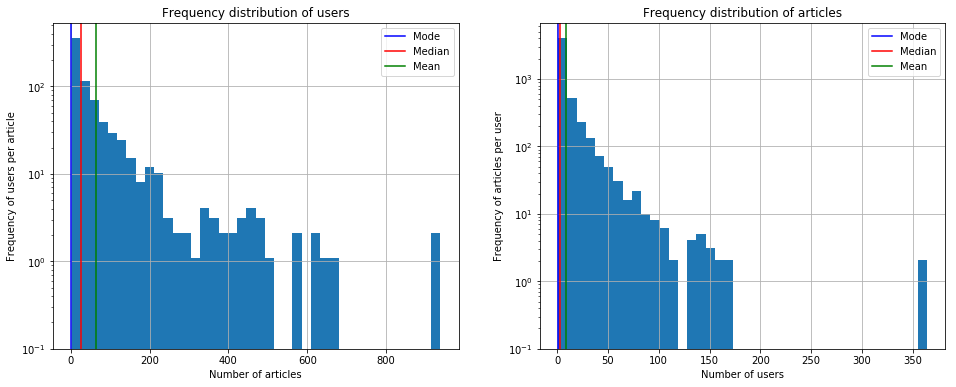

In [5]:
fig, (ax1, ax2) = plt.subplots(figsize=(16,6), nrows=1, ncols=2)


articles_distribution = df.groupby('article_id')['title'].count()
articles_distribution.hist(ax=ax1, bins=40, bottom=0.1)
ax1.set_yscale('log')
ax1.set_xlabel('Number of articles')
ax1.set_ylabel('Frequency of users per article')
ax1.set_title('Frequency distribution of users')
ax1.axvline(x=articles_distribution.min(), color='b', label='Mode')
ax1.axvline(x=articles_distribution.median(), color='r', label='Median')
ax1.axvline(x=articles_distribution.mean(), color='g', label='Mean')
ax1.legend()

users_distribution = df.groupby('email')['title'].count()
users_distribution.hist(ax=ax2, bins=40, bottom=0.1)
ax2.set_yscale('log')
ax2.set_xlabel('Number of users')
ax2.set_ylabel('Frequency of articles per user')
ax2.set_title('Frequency distribution of articles')
ax2.axvline(x=users_distribution.min(), color='b', label='Mode')
ax2.axvline(x=users_distribution.median(), color='r', label='Median')
ax2.axvline(x=users_distribution.mean(), color='g', label='Mean')
ax2.legend()

In [6]:
display(articles_distribution.describe(), users_distribution.describe())

count    714.000000
mean      64.415966
std      109.175923
min        1.000000
25%        8.000000
50%       25.000000
75%       69.000000
max      937.000000
Name: title, dtype: float64

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: title, dtype: float64

The distribution is clearly right skewed, means that there are few articles used 
most of the time/by most users, while most of the other articles are user by few 
users.

In [7]:
# Fill in the median and maximum number of user_article interactios below

median_val = users_distribution.median()# 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = users_distribution.max() # The maximum number of user-article interactions by any 1 user is ______.
median_val, max_views_by_user

(3.0, 364)

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [8]:
# Find and explore duplicate articles

In [9]:
# Remove any rows that have the same article_id - only keep the first

In [10]:
# get some infos about the two datasets
df.shape, df_content.shape

((45993, 3), (1056, 5))

*Is the `article_id` unique in the each of the two datasets?*

In [11]:
df.article_id.unique().shape[0], df_content.article_id.unique().shape[0]

(714, 1051)

It seems that:
1. there are many rows in the `df` dataset for each `article_id`.
2. the unique `article_id` in the `df_content` dataset =1051, which almost equals the dataset rows.
> it seems that the `df_content` contains duplicate rows, let's investigate

In [12]:
# the duplicates
df_content[df_content.duplicated(subset='article_id', keep=False)].sort_values(by='article_id')

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


There are 5 duplicates in the `article_id`, we will keep the first occurence.

In [13]:
df_content = df_content[~df_content.duplicated(subset='article_id', keep='first')]
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [14]:
# df.info()
print('Answers of a={}, b={}, c={}, d={}'.format(
    df.article_id.unique().shape[0], len(df_content.article_id.unique()),
    len(df.email.unique()), df.shape[0]))

Answers of a=714, b=1051, c=5149, d=45993


In [15]:
len(df[~df.email.isna()].email.unique())

5148

In [16]:
unique_articles = df.article_id.unique().shape[0]# The number of unique articles that have at least one interaction
total_articles = len(df_content.article_id.unique())# The number of unique articles on the IBM platform
unique_users = len(df[~df.email.isna()].email.unique())# The number of unique users
user_article_interactions = df.shape[0]# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [17]:
# top 5 articles
display(df.article_id.value_counts().iloc[:5, ],
        df.article_id.value_counts().iloc[:1, ].index[0],
        df.article_id.value_counts().iloc[:1, ].to_list()[0])

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: article_id, dtype: int64

1429.0

937

In [18]:
most_viewed=df.article_id.value_counts().iloc[:1,]
most_viewed_article_id = str(most_viewed.index[0])# The most viewed article in the dataset as a string with one value following the decimal 
max_views = most_viewed.to_list()[0]# The most viewed article in the dataset was viewed how many times?

In [19]:
type(most_viewed_article_id)

str

In [20]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column


def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []

    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter += 1

        email_encoded.append(coded_dict[val])
    return email_encoded


email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [21]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [22]:
n=3
tt=df.article_id.value_counts().iloc[:n, ].index.tolist()
tt
[df[df.article_id==id].iloc[0]['title'] for id in tt]
# df[df.article_id==id].iloc[0]['title']

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel']

In [23]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = [
        df[df.article_id == id].iloc[0]['title']
        for id in get_top_article_ids(n, df)
    ]
    # Return the top article titles from df (not df_content)
    return top_articles  


def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df.article_id.value_counts().iloc[:n, ].index.tolist()
    return top_articles  # Return the top article ids

In [24]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [25]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [26]:
list(df)

['article_id', 'title', 'user_id']

In [27]:
# Create an aggregate function to take 1 or 0
one_func = lambda x: 1 if sum(x)>0 else 0
# Test
[one_func(x) for x in ([0, 1, 0], [0,0,0], [0], [4, 2], [1], [np.nan, np.nan])]

[1, 0, 0, 1, 1, 0]

In [ ]:
# pd.pivot_table(
#     df,
#     values='title',
#     index=['user_id'],
#     columns=['article_id'],
#     aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0).astype(int)

In [109]:
# create the user-article matrix with 1's and 0's


def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = pd.pivot_table(
        df,
        values='title',
        index=['user_id'],
        columns=['article_id'],
        aggfunc=lambda x: 1 if len(x) > 0 else 0).fillna(0).astype(int)
    return user_item#.values  # return the user_item matrix


user_item = create_user_item_matrix(df)

In [29]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [55]:
# # tx=np.dot(user_item, user_item.loc[1])
# tx=user_item.dot(user_item.loc[1])
# # tx.sort()
# tx=tx.sort_values(ascending=False)
# tx.index.tolist()[:5]

In [31]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users 
                    (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    #similarity = np.dot(user_item, user_item.loc[user_id])
    similarity = user_item.dot(user_item.loc[user_id])
    # sort by similarity
    similarity = similarity.sort_values(ascending=False)
    # create list of just the ids
    most_similar_users = similarity.index.tolist()
    # remove the own user's id
    most_similar_users.remove(user_id)

    # return a list of the users in order from most to least similar
    return most_similar_users

In [32]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [33]:
# Trials
articles_ids = [2.0, 4.0, 8.0, 9.0, 12.0]
[df[df.article_id == id].iloc[0]['title'] for id in articles_ids]

['this week in data science (april 18, 2017)',
 'analyze ny restaurant data using spark in dsx',
 'data science bowl 2017',
 '3992    using apache spark to predict attack vectors a...\nName: title, dtype: object',
 'timeseries data analysis of iot events by using jupyter notebook']

In [ ]:
# user_id=1
# # df[df.user_id==user_id]['article_id'].unique()
# s=user_item.loc[user_id]
# s.where(s==1).dropna().index.tolist()

In [ ]:
# user_id=1
# collected = []
# # I will call the similar users 'friends'
# friends = find_similar_users(user_id)
# # The target user's items
# user_items = get_user_articles(user_id)[0]
# display(user_id, friends[:10], user_items[:10])

In [ ]:
# m=10
# # friend = 0
# col_num = len(collected)
# friend_items = get_user_articles(friends[friend])[0]
# selected = [x for x in friend_items if x not in user_items]
# lsel, lcol = len(selected), len(collected)
# diff = lsel + lcol - m
# if diff > 0:
#     # select random items counted as diff
#     selected = np.random.choice(selected, diff, 
#                                 replace=False).tolist()
#     print('her')
# if lsel >0:
#     collected.extend(selected)
# friend += 1
# friend, friends[friend], selected, lsel, lcol

In [ ]:
df.article_id.dtype==float
articles_ids=['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0']
type(articles_ids[0])==str

In [34]:
def correct_ids_datatype(ids, desired_datatype=int):
    '''
    A function to make the datatype of gived ids == the dataframe's datatype
    in:>
        ids: a list or iterable
        desired_datatype: the desired datatype (int, str, float)
    out:>
        a list of items with same datatype as desired
    
    '''
    if desired_datatype==int:
        return [int(float(x)) for x in ids]
    elif desired_datatype==float:
        return [float(x) for x in ids]
    elif desired_datatype==str:
        return [str(x) for x in ids]
    else:
        print('The desired datatype can only be int, float, or str')
        raise
# tests
ids=['1024.0', '1305.0', '1314.0',  '1427.0']
print([correct_ids_datatype(ids, dtyp) for dtyp in [int, float, str]])
ids=[1040, 2015, 1236]
print([correct_ids_datatype(ids, dtyp) for dtyp in [int, float, str]])
ids=[1050.0, 7015.0, 1896.0]
print([correct_ids_datatype(ids, dtyp) for dtyp in [int, float, str]])

[[1024, 1305, 1314, 1427], [1024.0, 1305.0, 1314.0, 1427.0], ['1024.0', '1305.0', '1314.0', '1427.0']]
[[1040, 2015, 1236], [1040.0, 2015.0, 1236.0], ['1040', '2015', '1236']]
[[1050, 7015, 1896], [1050.0, 7015.0, 1896.0], ['1050.0', '7015.0', '1896.0']]


In [35]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated 
                            with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    # check teh given index if it is string, float, or int:
    given_data_type = type(article_ids[0])
    dataframe_datatype = df.article_id.dtype
    if given_data_type != dataframe_datatype:
        articles_ids2 = correct_ids_datatype(article_ids, dataframe_datatype)
    else:
        articles_ids2=article_ids
        
    article_names = [
        df[df.article_id == id1].iloc[0]['title'] for id1 in articles_ids2
    ]
    return article_names  # Return the article names associated with list of article ids

In [36]:
def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) 
       a list of article names associated with the list of article ids 
       (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles 
                that have been seen by a user
    '''
    # Your code here
    # articles_ids = df[df.user_id==user_id]['article_id'].unique()
    s = user_item.loc[user_id]
    article_ids = s.where(s == 1).dropna().index.tolist()
    article_names = get_article_names(article_ids)
    return article_ids, article_names  # return the ids and names

In [39]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before 
    and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    collected = []
    # I will call the similar users 'friends'
    friends = find_similar_users(user_id)
    # The target user's items
    user_items = get_user_articles(user_id)[0]
    friend = 0

    while len(collected) < m:
        col_num = len(collected)
        friend_items = get_user_articles(friends[friend])[0]
        selected = [x for x in friend_items if x not in user_items]
        lsel, lcol = len(selected), len(collected)
        diff = lsel + lcol - m
        if diff > 0:
            # select random items counted as diff
            selected = np.random.choice(selected, diff, 
                                        replace=False).tolist()

        if lsel >0:
            collected.extend(selected)
        friend += 1
    recs = collected[:m]
    return recs  # return your recommendations for this user_id

In [40]:
get_user_articles(20)[0]

[232.0, 844.0, 1320.0]

In [41]:
# user_user_recs(1, 10)

In [42]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['502    forgetting the past to learn the future: long ...\nName: title, dtype: object',
 'maximize oil company profits',
 'healthcare python streaming application demo',
 'car performance data',
 'analyze open data sets with pandas dataframes',
 'brunel interactive visualizations in jupyter notebooks',
 'this week in data science (april 25, 2017)',
 'using deep learning with keras to predict customer churn',
 'pixieapp for outlier detection',
 'easy json loading and social sharing in dsx notebooks']

In [43]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(map(str, get_user_articles(20)[0])) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set((map(str, get_user_articles(2)[0]))) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 
                                            'build a python app on the streaming analytics service', 
                                            'gosales transactions for naive bayes model', 
                                            'healthcare python streaming application demo', 
                                            'use r dataframes & ibm watson natural language understanding', 
                                            'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [45]:
# user_id=5
# friend_similarity = user_item.dot(user_item.loc[user_id]).sort_values(ascending=False)#[1:]
# friend_activity = df.groupby('user_id')['article_id'].count()
# # remove the current user
# # ,columns=['similarity', 'activity']
# test=pd.concat([friend_similarity, friend_activity], axis=1)
# test.columns=['similarity', 'activity']
# test.index.names = ['neighbor_id']
# test=test[test.index!=user_id]
# test = test.sort_values(by=['similarity', 'activity'],ascending=False)
# test = test.reset_index()
# test

In [46]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of 
                    each user to the provided user_id
                    num_interactions - the number of articles 
                    viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and 
                    then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    friend_similarity = user_item.dot(user_item.loc[user_id]).sort_values(ascending=False)#[1:]
    friend_activity = df.groupby('user_id')['article_id'].count()
    # remove the current user
    # ,columns=['similarity', 'activity']
    neighbors_df=pd.concat([friend_similarity, friend_activity], axis=1)
    neighbors_df.columns=['similarity', 'activity']
    neighbors_df.index.names = ['neighbor_id']
    neighbors_df=neighbors_df[neighbors_df.index!=user_id]
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'activity'],ascending=False)
    neighbors_df = neighbors_df.reset_index()

    return neighbors_df  # Return the dataframe specified in the doc_string

#Test
get_top_sorted_users(1).head()

,neighbor_id,similarity,activity
0,3933,35,45
1,23,17,364
2,3782,17,363
3,203,15,160
4,4459,15,158


In [47]:
article_id = 12.0
article_interaction = df.groupby('article_id')['user_id'].count().to_frame(
    name='interaction').sort_values(
        by='interaction', ascending=False).reset_index()
article_interaction
selected =[1429, 1162.0, 1346.0, 984.0, 1790, 1052.0]
article_interaction[article_interaction.article_id.isin(selected)].article_id.tolist()

[1429.0, 1162.0, 1052.0, 1346.0, 984.0]

In [48]:
def get_top_sorted_articles(selected, df=df):
    '''
    INPUT:
    selected - list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook 
             
    OUTPUT:
    sorted_articles - (list) a sorted list of articles based on 
                            their attraction
                    
    Other Details - get a sorted list of articles based on their attraction
     
    '''
    # Your code here
    article_interaction = df.groupby('article_id')['user_id'].count().to_frame(
        name='interaction').sort_values(
            by='interaction', ascending=False).reset_index()
    article_interaction
    #     selected =[1429, 1162.0, 1346.0, 984.0, 1790, 1052.0]
    sorted_articles = article_interaction[article_interaction.article_id.isin(
        selected)].article_id.tolist()

    return sorted_articles  # Return the dataframe specified in the doc_string


#Test
selected =[1429, 1162.0, 1346.0, 984.0, 1790, 1052.0]
get_top_sorted_articles(selected)

[1429.0, 1162.0, 1052.0, 1346.0, 984.0]

In [ ]:
# m=10
# user_id=333
# collected = []
# # I will call the similar users 'friends'
# friends = get_top_sorted_users(user_id)['neighbor_id'].tolist()
# # The target user's items
# user_items = get_user_articles(user_id)[0]
# friend = 0
# while len(collected) < m:
# #     print(collected)
#     col_num = len(collected)
#     friend_items = get_user_articles(friends[friend])[0]
#     selected = [x for x in friend_items if x not in user_items]
#     lsel, lcol = len(selected), len(collected)
#     diff = lsel + lcol - m
#     if diff > 0:
#         # select random items counted as diff
#         selected = get_top_sorted_articles(selected)

#     if lsel >0:
#         collected.extend(selected)
#     friend += 1
# recs = collected[:m]
# recs  # return your recommendations for this user_id

In [49]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    collected = []
    # I will call the similar users 'friends'
    friends = get_top_sorted_users(user_id)['neighbor_id'].tolist()
    # The target user's items
    user_items = get_user_articles(user_id)[0]
    friend = 0
    while len(collected) < m:
    #     print(collected)
        col_num = len(collected)
        friend_items = get_user_articles(friends[friend])[0]
        selected = [x for x in friend_items if x not in user_items]
        lsel, lcol = len(selected), len(collected)
        diff = lsel + lcol - m
        if diff > 0:
            # select random items counted as diff
            selected = get_top_sorted_articles(selected)

        if lsel >0:
            collected.extend(selected)
        friend += 1
    recs = collected[:m]
    rec_names = get_article_names(recs)
    return recs, rec_names

In [50]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [51]:
get_top_sorted_users(131).loc[9]['neighbor_id']    

242

In [52]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).loc[0]['neighbor_id']# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).loc[9]['neighbor_id']    # Find the 10th most similar user to user 131

In [56]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

**My Response** For a new user, none of the *"near"* above functions would be suitable to get recommendations. because all of the above functions depend on user's similarity, which is not known for a new user. 

***A better approach*** to suggest the top articles that are used by other users (the articles with top interactions) This is performed by the very early function `get_top_article_ids` which seems to get a very good start for any *normal* user.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [58]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user,
# they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10) # Your recommendations here

In [59]:
assert set(map(str, new_user_recs)) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [3]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [4]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [5]:
# Perform SVD on the User-Item Matrix Here

# use the built in to get the three matrices
u, s, vt = np.linalg.svd(user_item_matrix)#, full_matrices=False)
[f'Matrix {mtrx_l} shape is: {mtrx.shape}' for mtrx_l, mtrx in zip(('u', 's', 'vt'),(u, s, vt))]

['Matrix u shape is: (5149, 5149)',
 'Matrix s shape is: (714,)',
 'Matrix vt shape is: (714, 714)']

**Provide your response here.**
***
***My response***
* The `U` matrix is a square matrix contains all the users in the dataset in rows and number of latent features in columns.
* The `Vt` matrix is a square matrix contains the number of articles in columns, and equal latent features in rows.
* The `s` matrix is a vector contains the diagonal of a square matrix of latent features in rows and columns.

In the movie-user dataset, we have the SVD contains ratings of each user to each movie, hence we had some movies that were unrated by some users; hence we had some missing values (NaNs) that we imputed them by Func method to be able to slove the matrices.

In this case, we have each user either interacted with an article `(1)` or not `(0)`. Thus we have no NaNs here, and we can apply SVD without Func method.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [6]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)

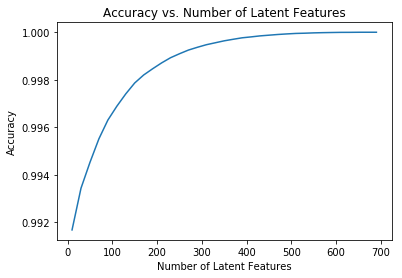

In [7]:
# Plotting   
# plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/user_item_est.size);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [9]:
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded
# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [10]:
df_train = df.head(40000)
df_test = df.tail(5993)

In [11]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    mapping = {True:1, False:0}
    
    user_item_df = df.groupby(['user_id', 'article_id'])['title'].max().unstack()
    user_item_df = ~user_item_df.isnull() #True is not empty, false is empty
    user_item = user_item_df.applymap(lambda x: mapping[x])
    
    return user_item # return the user_item matrix 

In [12]:
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index  #.unique()  #.tolist()
    test_arts = user_item_test.columns  #.unique()  #.tolist()
    return user_item_train, user_item_test, test_idx, test_arts


user_item_train, user_item_test, test_idx, test_arts = \
create_test_and_train_user_item(df_train, df_test)

# Check
[j.shape for j in (user_item_train, user_item_test, test_idx, test_arts)]

[(4487, 714), (682, 574), (682,), (574,)]

In [13]:
user_item_train.sum().sum(), user_item_test.sum().sum(), sum(test_idx), sum(test_arts)

(29264, 4445, 3265571, 431455.0)

In [14]:
train_idx, train_arts = user_item_train.index, user_item_train.columns

In [15]:
[
    mtrx.shape for mtrx in (user_item_train, user_item_test, test_idx,
                            test_arts, train_idx, train_arts)
]

[(4487, 714), (682, 574), (682,), (574,), (4487,), (714,)]

To predict articles from a test dataset

In [16]:
# Common articles and common users in both training and testing datasets
common_users= list(set(train_idx).intersection(test_idx))
common_articles= list(set(train_arts).intersection(test_arts))
print(common_users,len(common_users), len(common_articles))

[3968, 4231, 4487, 3093, 3989, 3990, 3740, 3998, 4002, 4274, 3777, 4293, 3527, 3532, 3024, 3801, 3684, 2917, 4204, 3193] 20 574


In [17]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 

In [201]:
print('How many users can we make predictions '
      'for in the test set?\n\tAnswer: ',
      len(common_users))
print('How many users in the test set are we not able to make '
       'predictions for because of the cold start problem?\n\tAnswer: ', 
      test_idx.shape[0]- len(common_users) )
print('How many articles can we make predictions '
      'for in the test set?\n\tAnswer: ',
      len(common_articles))
print('How many articles in the test set are we not able to make '
       'predictions for because of the cold start problem?\n\tAnswer: ', 
      test_arts.shape[0]- len(common_articles) )

How many users can we make predictions for in the test set?
	Answer:  20
How many users in the test set are we not able to make predictions for because of the cold start problem?
	Answer:  662
How many articles can we make predictions for in the test set?
	Answer:  574
How many articles in the test set are we not able to make predictions for because of the cold start problem?
	Answer:  0


> The dictionary below was containing a mistake; they wrote `articles`, while they check for `movies`!<br>
I have changed the correct `articles` word to the mistaken `movies` word to match the *mistaken* testing dictionary.

In [202]:
sol_4_dict = {
    'How many users can we make predictions for in the test set?':
    c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?':
    a,
    'How many movies can we make predictions for in the test set?':
    b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?':
    d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [19]:
# Use these cells to see how well you can use the training
# decomposition to predict on test data

# fit SVD on the user_item_train matrix
# fit svd similar to above then use the cells below
u_train, s_train, vt_train = np.linalg.svd(
    user_item_train)#, full_matrices=False)

In [72]:
train_idx = user_item_train.index

common_users= list(set(train_idx).intersection(test_idx))
common_arts = user_item_train.columns.intersection(test_arts)

# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)
print('train: ', u_train.shape, s_train.shape, vt_train.shape)

#get the index of the common users in train and test idx
train_common_users = user_item_train.index.isin(test_idx)
train_common_arts = user_item_train.columns.isin(test_arts)

u_test = u_train[train_common_users, :]
s_test = s_train
vt_test = vt_train[:, train_common_arts]
print('test: ', u_test.shape, vt_test.shape)

user_item_test = user_item_test.loc[common_users]

train:  (4487, 4487) (714,) (714, 714)
test:  (20, 4487) (714, 574)


In [73]:
sum_train_errs = []
sum_test_errs = []
all_errs = []
#make predictions based on train_set SVD for the overlapping 20 users that are also in the test set
#compare these predictions with the actual test matrix to get errer
num_latent_features = np.arange(5, 710, 100)

for k in num_latent_features: 
    u_train_lat, s_train_lat, vt_train_lat = u_train[:, :k], np.diag(
        s_train[:k]), vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    s_test_lat = s_train_lat
    
    user_item_train_est = np.around(
        np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_est = np.around(
        np.dot(np.dot(u_test_lat, s_test_lat), vt_test_lat))
    
    # Difference calculation
    diffs_train = np.subtract(user_item_train, user_item_train_est)
    diffs_test = np.subtract(user_item_test.loc[common_idx, :],
                             user_item_test_est)
    
    # Errors calculations
    sum_train_errs.append(diffs_train.abs().sum().sum())

    sum_test_errs.append(diffs_test.abs().sum().sum())
    
    all_errs.append(user_item_test.sum().sum() + user_item_test_est.sum())

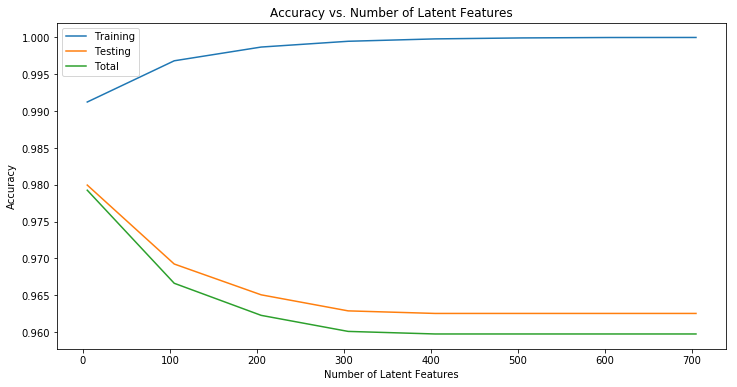

In [74]:
def accuracy_equiv(list_x, array_x):
    return 1 - (np.array(list_x) / (array_x.size))


#plotting accuracy
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(
    num_latent_features,
    accuracy_equiv(sum_train_errs, user_item_train),
    label='Training')

plt.plot(
    num_latent_features,
    accuracy_equiv(sum_test_errs, user_item_test),
    label='Testing')

plt.plot(
    num_latent_features,
    accuracy_equiv(all_errs, user_item_test),
    label='Total')

plt.legend()
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features');

In [51]:
# Get prediction of the common users
common_users_locations = user_item_train.index.isin(test_idx)
# get common items with the test dataset
common_items_locations = user_item_train.columns.isin(test_arts)

# common_users_matrix
common_users_matrix = u_train[common_users_locations, :]  #.shape{U_TEST}
# Common articles matrix
common_articles_matrix = vt_train[:, common_items_locations]  # {vt_test}
u_test = common_users_matrix
vt_test = common_articles_matrix
common_idx=common_users
# get the predictions
# A= U.s.Vt
# pred = np.dot(np.dot(common_users_matrix,np.diag(s_train)), vt_train)
# sum(sum(pred))

# the adapted pred matrix
# pred_adapted = pred[:,common_items_locations]
# Check
# pred.shape, pred_adapted.shape
user_item_test2 = user_item_test.loc[common_users]

In [21]:
user_item_test.loc[[4487,4231]].describe().sum(axis=1)

count    1148.000000
mean       10.000000
std        14.142136
min         0.000000
25%         5.000000
50%        10.000000
75%        15.000000
max        20.000000
dtype: float64

In [22]:
k=15
u_train_lat, s_train_lat, vt_train_lat = u_train[:, :k], np.diag(s_train[:k]), vt_train[:k, :]
u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k,:]
user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
# all_errs.append(1 - ((np.sum(user_item_test_preds)+np.sum(np.sum(user_item_test)))/(user_item_test.shape[0]*user_item_test.shape[1])))
#calculate error
diffs_train = np.subtract(user_item_train, user_item_train_preds)
diffs_test = np.subtract(user_item_test.loc[common_idx, :], user_item_test_preds)
train_err = np.sum(np.sum(np.abs(diffs_train))) #first sum cols then rows
# sum_train_errs.append(train_err)

test_err = np.sum(np.sum(np.abs(diffs_test)))
print([
    tst.sum()
    for tst in (u_train_lat, s_train_lat, vt_train_lat, u_test_lat,
                vt_test_lat, user_item_train_preds, user_item_test_preds,
               )
], sum(diffs_train), sum(diffs_test), train_err, test_err)


[-56.34871625622461, 301.25043576520625, -19.949637744286633, -0.28221490002804894, -20.161143042071448, 5565.0, 58.0] 567618.0 431455.0 24753.0 254.0


In [230]:
k = 15
u_train_latent, s_train_latent, vt_train_latent = u_train[:, :k], np.diag(
    s_train[:k]), vt_train[:k, :]
u_test_latent = common_users_matrix[:, :k]
vt_test_latent = common_articles_matrix[:k, :]

# take dot product
user_item_est_train = np.around(
    np.dot(np.dot(u_train_latent, s_train_latent), vt_train_latent))
user_item_est_test = np.around(
    np.dot(np.dot(u_test_latent, s_train_latent), vt_test_latent))

# compute error for each prediction to actual value ## user_item_train
diffs_train = np.subtract(user_item_train, user_item_est_train)
diffs_test = np.subtract(user_item_test2.loc[common_users, :],
                         user_item_est_test)

# # total errors and keep track of them
err_train = np.sum(np.sum(np.abs(diffs_train)))
# sum_errs_train.append(err_train)
err_test = np.sum(np.sum(np.abs(diffs_test)))
# sum_errs_test.append(err_test)

# #     sum_errs_total.append(1-((np.sum(user_item_test)+np.sum(user_item_est_test))/user_item_test.size))
# sum_errs_total.append(np.sum(user_item_test) + np.sum(user_item_est_test))

In [231]:
print([
    tst.sum()
    for tst in (u_train_latent, s_train_latent, vt_train_latent, u_test_latent,
                vt_test_latent, user_item_est_train, user_item_est_test)
], sum(diffs_train), sum(diffs_test), err_train, err_test)

[-56.34871625622461, 301.25043576520625, -19.949637744286633, -0.28221490002804894, -20.161143042071448, 5565.0, 58.0] 567618.0 431455.0 24753.0 254.0


In [232]:
sum(diffs_train) #df
diffs_train
np.sum(np.sum(np.abs(diffs_train))), np.sum(np.sum(np.abs(diffs_test)))

(24753.0, 254.0)

In [178]:
np.sum(np.abs(diffs_test), axis=1).sort_index()

user_id
2917     4.0
3024     7.0
3093     5.0
3193     6.0
3527     1.0
3532    33.0
3684     5.0
3740    53.0
3777     3.0
3801    29.0
3968     8.0
3989     1.0
3990     9.0
3998     8.0
4002    10.0
4204    11.0
4231    24.0
4274     7.0
4293    26.0
4487     4.0
dtype: float64

In [141]:
# num_latent_feats = np.arange(10, 710, 20)
num_latent_feats = np.arange(5, 710, 10)
sum_errs_test = []
sum_errs_train = []
sum_errs_total = []
for k in num_latent_feats:
    # restructure with k latent features
    s_train_latent, u_train_latent, vt_train_latent = np.diag(
        s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_latent = common_users_matrix[:, :k]
    vt_test_latent = common_articles_matrix[:k, :]

    # take dot product
    user_item_est_train = np.around(
        np.dot(np.dot(u_train_latent, s_train_latent), vt_train_latent))
    user_item_est_test = np.around(
        np.dot(np.dot(u_test_latent, s_train_latent), vt_test_latent))

    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_est_train)
    diffs_test = np.subtract(user_item_test.loc[common_users, :],
                             user_item_est_test)

    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    sum_errs_train.append(err_train)
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_test.append(err_test)

    #     sum_errs_total.append(1-((np.sum(user_item_test)+np.sum(user_item_est_test))/user_item_test.size))
    sum_errs_total.append(np.sum(user_item_test) + np.sum(user_item_est_test))

In [146]:
sum(sum_errs_train), sum(sum_errs_test)
sum_errs_test

[230.0,
 254.0,
 275.0,
 290.0,
 296.0,
 308.0,
 318.0,
 329.0,
 342.0,
 347.0,
 353.0,
 361.0,
 367.0,
 370.0,
 377.0,
 380.0,
 383.0,
 389.0,
 395.0,
 398.0,
 401.0,
 408.0,
 408.0,
 409.0,
 413.0,
 415.0,
 416.0,
 420.0,
 422.0,
 424.0,
 426.0,
 426.0,
 426.0,
 426.0,
 428.0,
 428.0,
 428.0,
 429.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0,
 430.0]

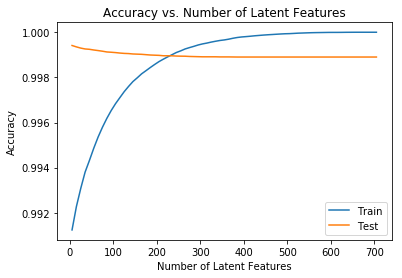

In [142]:
plt.plot(
    num_latent_feats,
    1 - np.array(sum_errs_train) / user_item_train.size,
    label='Train')
plt.plot(
    num_latent_feats,
    1 - np.array(sum_errs_test) / user_item_test.size,
    label='Test')
# plt.plot(
#     num_latent_feats,
#     1 - np.array(sum_errs_total) / user_item_test.size,
#     label='Total')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend();

In [131]:
# # Get actual values of the common users

# user_item_subset = user_item_test.loc[common_users,:]
# user_item_subset.values.shape

In [132]:
# # Calculate the error in prediction
# sum_square_errors = np.round(
#     np.sum(np.sum((user_item_subset - pred_adapted)**2)), 2)
# sum_square_errors

In [78]:
# # Calculate the goodness of prediction

# # Total sum squares
# data_mean = np.mean(np.mean(user_item_subset))
# sum_square_total = np.round(
#     np.sum(np.sum((user_item_subset - data_mean)**2)), 2)
# sum_square_total

# # Determination coefficient 
# r_squared = 1- sum_square_errors/sum_square_total

In [80]:
# repeating the above lines to be in one place
u_train, s_train, vt_train = np.linalg.svd(
    user_item_train, full_matrices=True)
print([j.shape for j in [u_train, s_train, vt_train]])

common_users_locations_tr = user_item_train.index.isin(user_item_test.index)
common_items_locations_tr = user_item_train.columns.isin(
    user_item_test.columns)

common_users_locations_ts = user_item_test.index.isin(user_item_train.index)
common_items_locations_ts = user_item_test.columns.isin(
    user_item_train.columns)

u_test_common = u_train[common_users_locations_tr, :]
vt_test_common = vt_train[:, common_items_locations_tr]
# u_test, s_test, vt_test = np.linalg.svd(user_item_test, full_matrices=True)
# u_test_common = u_test[common_users_locations_ts, :]
# vt_test_common = vt_test[:, common_items_locations_ts]
print([j.shape for j in [u_test_common, s_train, vt_test_common]])
# user_item_test_common = user_item_test.loc[common_users, :]

[(4487, 4487), (714,), (714, 714)]
[(20, 4487), (714,), (714, 574)]


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**
***
***My comments***
The results show that the training prediction accuracy increases with the increase with the number of latent features, till it approaches 1.00 when the number of latent features equals the number of items.

On the other hand, the prediction accuracy decreases slightly with the increase of the latent features, which is a bit strange! However it could be attributed to the small number of common users and articles between the training and testing datasets, which might lead to overfitting problems (we use the data of about 4000 users to test for 20 users only)

In all ways, the accuracy is above 0.998 for the testing dataset, which is very good. Nevertheless, it is advised to 
1. use small number  of latent features
2. increase the size of the training and testing datasets.
3. perform several trainings and testing on random interactions (not as we did hhere by selecting head and tail of a dataset), we could select using `df.sample(0.8 * df.shape[0])` for training and the same for testing by replacing `0.2` by the `0.8` in the formula.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])